# Use File for Presentation Visualizations

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.cluster import KMeans


from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
#from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# USE sagemaker.xgboost when using AWS

from xgboost import XGBClassifier
from xgboost import plot_importance

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict

cmaps = OrderedDict()

import plotly 

this is _switch_path ---- path =  C:\Users\morga\OneDrive\Documents\20_Galvanize\12_capstone\Supervised-ML\chi-traffic-accidents
this is _switch_path ---- path =  C:\Users\morga\Anaconda3\python37.zip
this is _switch_path ---- path =  C:\Users\morga\Anaconda3\DLLs
this is _switch_path ---- path =  C:\Users\morga\Anaconda3\lib
this is _switch_path ---- path =  C:\Users\morga\Anaconda3
this is _switch_path ---- path =  
this is _switch_path ---- path =  C:\Users\morga\Anaconda3\lib\site-packages


---
## User-Defined Functions

In [3]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


---
## Data Preprocessing and EDA

C:\Users\morga\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


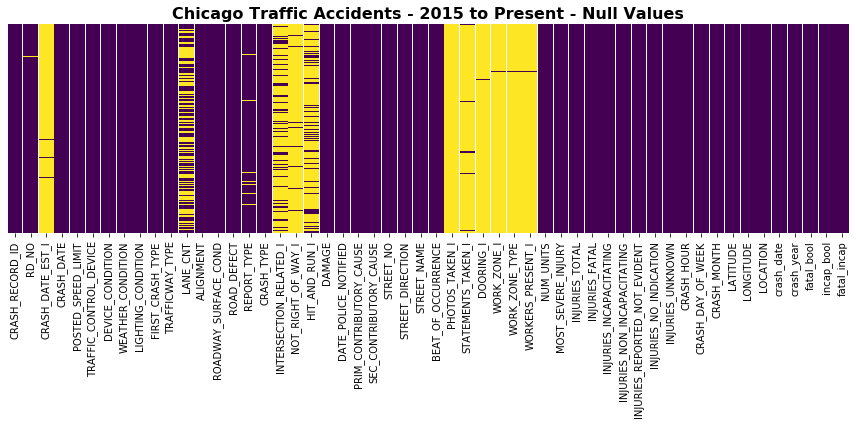

In [4]:
accidents = pd.read_csv('data/traffic_crashes.csv')


# Develop classification flag.
# Positive represents the accideent resulted in incapacitation and/or fatality.
accidents['crash_date'] = pd.to_datetime(accidents['CRASH_DATE'])
accidents['crash_year'] = accidents['crash_date'].dt.year
accidents['fatal_bool'] = np.where(accidents['MOST_SEVERE_INJURY'] == 'FATAL', 1, 0)
accidents['incap_bool'] = np.where(accidents['MOST_SEVERE_INJURY'] == 'INCAPACITATING INJURY', 1, 0)
accidents['fatal_incap'] = accidents['fatal_bool'] + accidents['incap_bool']

# Check for null values.
plt.figure(figsize=(12,6))
sns.heatmap(accidents.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Chicago Traffic Accidents - 2015 to Present - Null Values', fontsize=16, fontweight='bold')
plt.tight_layout();

In [5]:
# Started collecting data for the entire city in September 2017.
# Data collection became more formalized.
# Omitting data prior to March 2020 due to Covid-19 pandemic.
accidents = accidents[(accidents['crash_date'] > '2017-08-31') & (accidents['crash_date'] < '2020-03-01')]
num_pos_obs = sum(accidents['fatal_incap'])
num_neg_obs = len(accidents['fatal_incap']) - num_pos_obs
print("# of POSITIVE Obs.: ", num_pos_obs)
print("# of NEGATIVE Obs.: ", num_neg_obs)
print("% of Positive Obs. (Fatalities): ", round(sum(accidents['fatal_incap']) / len(accidents['fatal_incap']), 4))

# of POSITIVE Obs.:  5358
# of NEGATIVE Obs.:  286722
% of Positive Obs. (Fatalities):  0.0183


Returns TRUE if Total # of Accidents Reconcile:  True


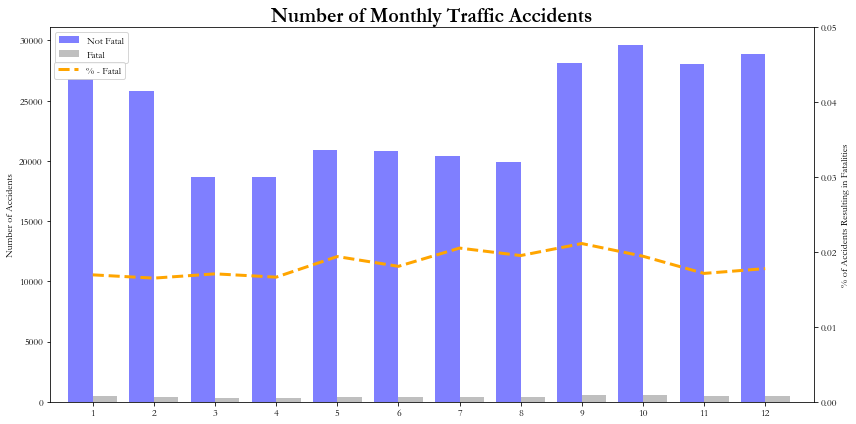

In [12]:
# Create data frame
month_grpd = accidents.groupby(['CRASH_MONTH', 'fatal_incap']).agg({'fatal_incap':'count'})
month_grpd.columns = ['count']
month_grpd.reset_index(inplace=True)
month_no_fatal_incap = month_grpd[month_grpd['fatal_incap'] == 0]
month_fatal_incap = month_grpd[month_grpd['fatal_incap'] == 1]

month_fatal_df = pd.DataFrame()
month_fatal_df['month'] = pd.Series(range(1,13))
month_fatal_df['num_not_fatal'] = np.array(month_grpd[month_grpd['fatal_incap'] == 0]['count'])
month_fatal_df['num_fatal'] = np.array(month_grpd[month_grpd['fatal_incap'] == 1]['count'])
month_fatal_df['total'] = month_fatal_df['num_not_fatal'] + month_fatal_df['num_fatal']
month_fatal_df['prcnt_fatal'] = month_fatal_df['num_fatal'] / month_fatal_df['total']

pos = list(range(len(month_fatal_df['month'])))
width = 0.4


# Create
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(pos, month_fatal_df['num_not_fatal'], width, alpha=0.5, color='b', label='Not Fatal')
ax1.bar([p + width for p in pos], month_fatal_df['num_fatal'], width, alpha=0.5, color='grey', label='Fatal')
ax1.set_ylabel('Number of Accidents')
ax1.set_xticks([p + 0.5 * width for p in pos])
ax1.set_xticklabels(month_fatal_df['month'])
ax1.set_title('Number of Monthly Traffic Accidents', fontsize=20, fontweight='bold')

ax1.set_xlim(-0.5, 12)

ax1.legend(loc='upper left', facecolor='white')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.grid(color=None, linestyle='None')
ax1.set_facecolor('white')
plt.rcParams['font.family'] = 'garamond'

# Share x-axis
ax2=ax1.twinx()

ax2.set_ylabel('% of Accidents Resulting in Fatalities')
ax2.set_ylim(0,0.05)
ax2.plot([p + width/2 for p in pos], month_fatal_df['prcnt_fatal'] , color='orange', linestyle='--', linewidth=3, 
         label='% - Fatal')

ax2.legend(bbox_to_anchor=(0, 0, 0.105, 0.92), facecolor='white')
ax2.grid(color=None, linestyle='None')
plt.tight_layout();

# check math
print("Returns TRUE if Total # of Accidents Reconcile: ", (sum(month_fatal_df['total'])==len(accidents)))

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='CRASH_MONTH', data=accidents, hue='fatal_incap', labels=['Non-fatal', 'Fatal'])
plt.title("Result of Accident by Month", fontsize=16, fontweight='bold');

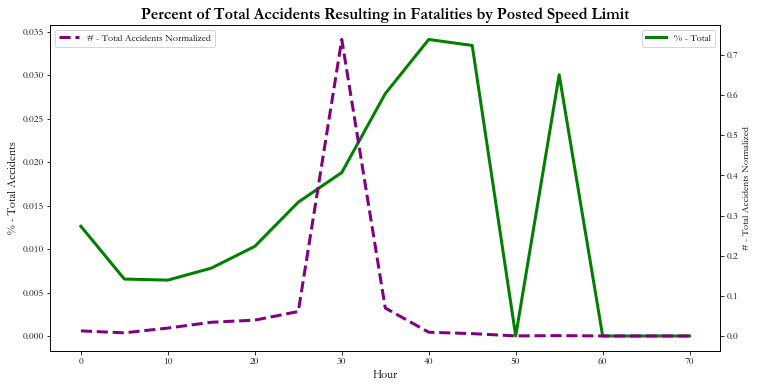

In [15]:
# ACCIDENTS BY DAY OF THE WEEK

accidents_spd_lim = accidents[accidents['POSTED_SPEED_LIMIT'] % 5 == 0].copy()
spd_lim_pivot = accidents_spd_lim.pivot_table(index='POSTED_SPEED_LIMIT', columns='fatal_incap', values='CRASH_RECORD_ID',
                                              fill_value=0, aggfunc='count').reset_index()
#spd_lim_pivot.drop('fatal_incap', axis=1, inplace=True)
spd_lim_pivot.rename({0:'num_not_fatal', 1:'num_fatal'}, axis=1, inplace=True)
spd_lim_pivot['total'] = spd_lim_pivot['num_not_fatal'] + spd_lim_pivot['num_fatal']
spd_lim_pivot['prcnt_fatal'] = spd_lim_pivot['num_fatal'] / spd_lim_pivot['total']

fig, ax = plt.subplots(figsize=(12,6))
spd_arr = spd_lim_pivot['POSTED_SPEED_LIMIT'].values
spd_prcnt_fatal_arr = spd_lim_pivot['prcnt_fatal'].values
spd_total_arr_nrml = spd_lim_pivot['total'].values / sum(spd_lim_pivot['total'])

ax.plot(spd_arr, spd_prcnt_fatal_arr , color='green',  linewidth=3, label='% - Total')
ax.set_title('Percent of Total Accidents Resulting in Fatalities by Posted Speed Limit', fontsize=16, fontweight='bold')
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('% - Total Accidents', fontsize=12)
ax.legend()

# Share x-axis
ax2=ax.twinx()

#ax2.set_ylim(0, 100000)
ax2.set_ylabel('# - Total Accidents Normalized')
ax2.plot(spd_arr, spd_total_arr_nrml , color='purple', linestyle='--', linewidth=3, 
         label='# - Total Accidents Normalized')

ax2.legend(loc='upper left', facecolor='white')
ax2.grid(color=None, linestyle='None')

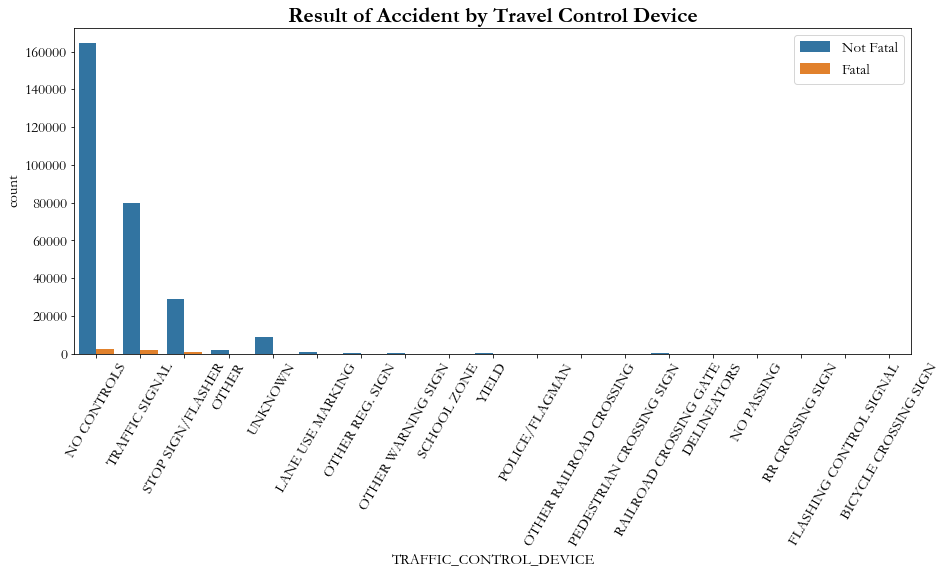

In [38]:
plt.figure(figsize=(15,6))
sns.countplot(x='TRAFFIC_CONTROL_DEVICE', data=accidents, hue='fatal_incap')
plt.title("Result of Accident by Travel Control Device", fontsize=22, fontweight='bold')
plt.legend(labels=['Not Fatal', 'Fatal'])
plt.xticks(rotation=60);

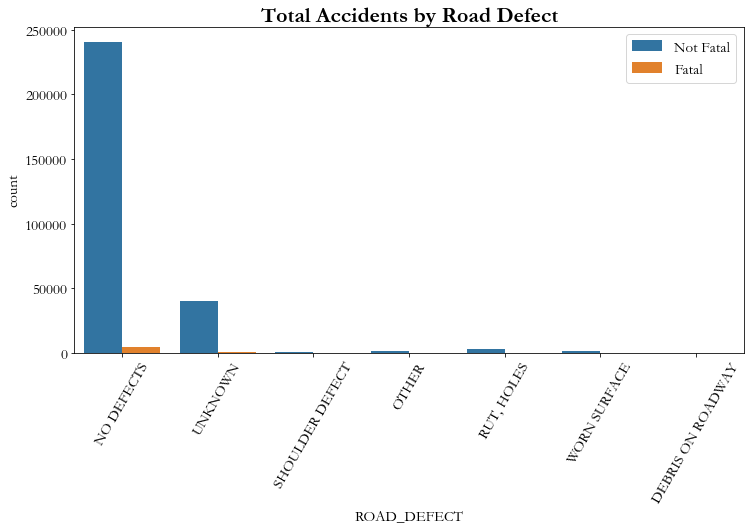

In [37]:
plt.figure(figsize=(12,6))
sns.countplot(x='ROAD_DEFECT', data=accidents, hue='fatal_incap')
plt.title("Total Accidents by Road Defect", fontsize=22, fontweight='bold')
plt.legend(labels=['Not Fatal', 'Fatal'])
plt.xticks(rotation=60);

AttributeError: 'Rectangle' object has no property 'labels'

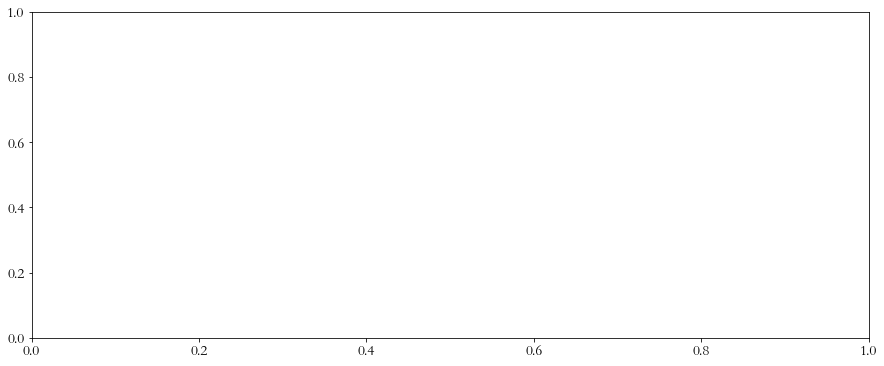

In [36]:
plt.figure(figsize=(15,6))
sns.countplot(x='POSTED_SPEED_LIMIT', data=accidents, hue='fatal_incap', labels=['Not Fatal', 'Fatal'])
plt.title("Total Accidents by Post Speed Limit", fontsize=22, fontweight='bold')
plt.xticks(rotation=60);

In [ ]:
# TRAFFIC ACCIDENTS BY DAY OF THE WEEK

day_pivot = accidents.pivot_table(index='CRASH_DAY_OF_WEEK', columns='fatal_incap', values='CRASH_RECORD_ID',
                                              fill_value=0, aggfunc='count').reset_index()
#spd_lim_pivot.drop('fatal_incap', axis=1, inplace=True)
day_pivot.rename({0:'num_not_fatal', 1:'num_fatal'}, axis=1, inplace=True)
day_pivot['total'] = day_pivot['num_not_fatal'] + day_pivot['num_fatal']
day_pivot['prcnt_fatal'] = day_pivot['num_fatal'] / day_pivot['total']

fig, ax = plt.subplots(figsize=(12,6))
day_arr = day_pivot['CRASH_DAY_OF_WEEK'].values
day_prcnt_fatal_arr = day_pivot['prcnt_fatal'].values
#day_total_arr_nrml = spd_lim_pivot['total'].values / sum(spd_lim_pivot['total'])

ax.plot(day_arr, day_prcnt_fatal_arr , color='green',  linewidth=3, label='% - Total')
ax.set_title('Percent of Total Accidents Resulting in Fatalities by Day of the Week', fontsize=16, fontweight='bold')
ax.set_xlabel('Day of the Week', fontsize=12)
ax.set_ylabel('% - Total Accidents', fontsize=12)
ax.legend()

fig.tight_layout()
print("Returns TRUE if Total # of Accidents Reconcile: ", (sum(day_pivot['total'])==len(accidents)))

---
# Presentation Visualizations

In [24]:
# Excluded "after-the-fact" features, e.g. DAMAGE($), DOORING_I
# Omitted geospatial data, SEC_CONTRIBUTORY_CAUSE, LANE_CNT.
# Construction information does not provide significant value.
# Removed CRASH_TYPE because its values are the results of the accidents.
accidents2 = accidents[['CRASH_RECORD_ID', 'RD_NO', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                        'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
                        'ALIGNMENT','ROADWAY_SURFACE_COND','ROAD_DEFECT', 
                        'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 
                        'PRIM_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION', 
                        'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
                        'crash_date', 'crash_year','fatal_incap']].copy()

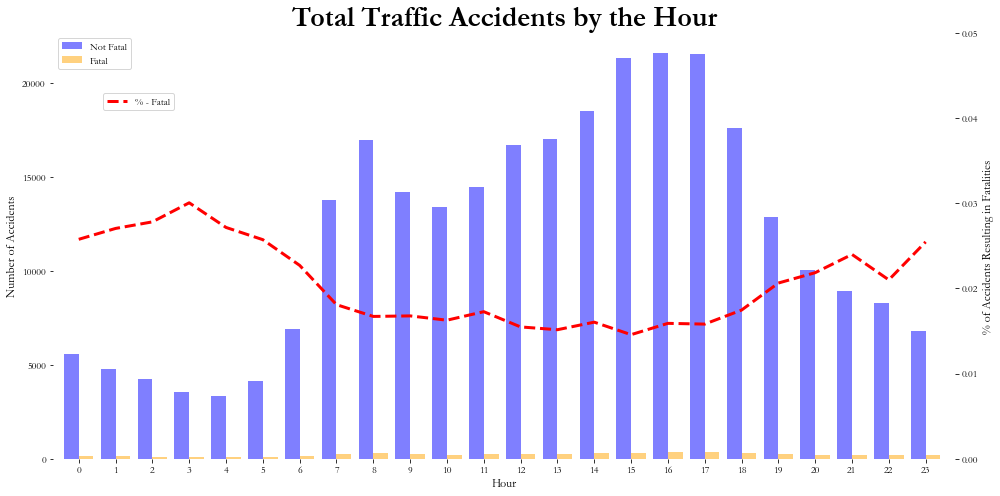

In [25]:
# ACCIDENTS BY HOUR
hour_grpd = accidents2.groupby(['CRASH_HOUR', 'fatal_incap']).agg({'fatal_incap':'count'})
hour_grpd.columns = ['count']
hour_grpd.reset_index(inplace=True)
hour_no_fatal = hour_grpd[hour_grpd['fatal_incap'] == 0]
hour_fatal_ = hour_grpd[hour_grpd['fatal_incap'] == 1]

hour_fatal_df = pd.DataFrame()
hour_fatal_df['hour'] = pd.Series(range(0,24))
hour_fatal_df['num_not_fatal'] = np.array(hour_grpd[hour_grpd['fatal_incap'] == 0]['count'])
hour_fatal_df['num_fatal'] = np.array(hour_grpd[hour_grpd['fatal_incap'] == 1]['count'])
hour_fatal_df['total'] = hour_fatal_df['num_not_fatal'] + hour_fatal_df['num_fatal']
hour_fatal_df['prcnt_fatal'] = hour_fatal_df['num_fatal'] / hour_fatal_df['total']

pos_hour = list(range(len(hour_fatal_df['hour'])))
width = 0.4


# Create
fig, ax1 = plt.subplots(figsize=(14,7))

ax1.bar(pos_hour, hour_fatal_df['num_not_fatal'], width, alpha=0.5, color='b', label='Not Fatal')
ax1.bar([p + width for p in pos_hour], hour_fatal_df['num_fatal'], width, alpha=0.5, color='orange', label='Fatal')
ax1.set_ylabel('Number of Accidents', fontsize=12)
ax1.set_xticks([p + 0.5 * width for p in pos_hour])
ax1.set_xticklabels(hour_fatal_df['hour'])
ax1.set_xlabel('Hour', fontsize=12)
ax1.set_title('Total Traffic Accidents by the Hour', fontsize=28, fontweight='bold')

ax1.set_xlim(-0.5, len(hour_fatal_df))

ax1.legend(loc='upper left', facecolor='white')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.grid(color=None, linestyle='None')
ax1.set_facecolor('white')


# Share x-axis
ax2=ax1.twinx()

ax2.set_ylabel('% of Accidents Resulting in Fatalities', fontsize=12)
ax2.set_ylim(0,0.05)
ax2.plot([p + width/2 for p in pos_hour], hour_fatal_df['prcnt_fatal'] , color='red', linestyle='--', linewidth=3, 
         label='% - Fatal')

ax2.legend(bbox_to_anchor=(0, 0, 0.14, 0.87), facecolor='white')
ax2.grid(color=None, linestyle='None')
plt.rcParams['font.family'] = 'garamond'


ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
plt.tight_layout();


fig.savefig('images/hourly_trend.png')
# check math
#print("Returns TRUE if Total # of Accidents Reconcile: ", (sum(hour_fatal_df['total'])==len(accidents)))

In [26]:
# Calculate average probability of accident resulting in a fatality
# Average for night and early AM.
night_early_am = hour_fatal_df[(hour_fatal_df['hour'] >= 20) | (hour_fatal_df['hour'] <=6)]
night_avg = night_early_am['prcnt_fatal'].mean()

# Average for day.
day_time = hour_fatal_df[(hour_fatal_df['hour'] < 20) & (hour_fatal_df['hour'] > 6)]
day_avg = day_time['prcnt_fatal'].mean()

print("{:.0%} more likely to result in fatality if accident occured in the night/early AM.".format(night_avg/day_avg-1))

52% more likely to result in fatality if accident occured in the night/early AM.


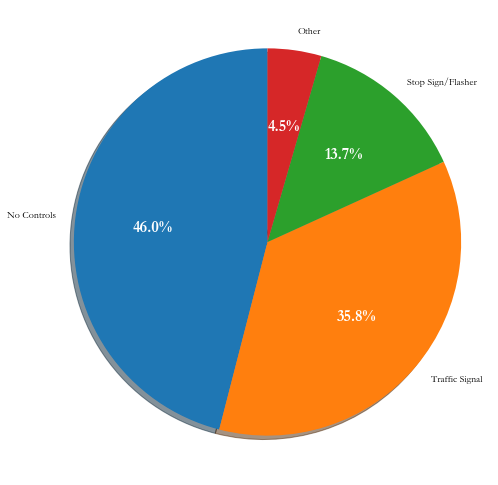

In [27]:
fatal_only_2 = accidents2[accidents2['fatal_incap'] == 1]

device_pivot = fatal_only_2.pivot_table(index='TRAFFIC_CONTROL_DEVICE', values='CRASH_RECORD_ID',
                                              fill_value=0, aggfunc='count').reset_index()
device_pivot.columns = ['desc', 'total']
device_pivot.sort_values(by='total', inplace=True, ascending = False)
device_pivot['prcnt_total'] = device_pivot['total'] / sum(device_pivot['total'])
device_pivot.reset_index(inplace=True)
device_pivot.drop('index', axis=1, inplace=True)

no_controls = device_pivot.at[0, 'prcnt_total']
traffic_signal = device_pivot.at[1, 'prcnt_total']
stop_flasher = device_pivot.at[2, 'prcnt_total']
other = 1-(no_controls + traffic_signal + stop_flasher)
pie_vals = np.array([no_controls, traffic_signal, stop_flasher, other])
cntrl_labels = ['No Controls', 'Traffic Signal', 'Stop Sign/Flasher', 'Other']


fig, ax = plt.subplots(figsize=(7,7))
ax.axis('equal')  
_, _, autotexts = ax.pie(pie_vals, startangle=90, labels=cntrl_labels, autopct='%1.1f%%', shadow=True)
                        
mpl.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'garamond'
plt.setp(autotexts, weight='bold', size = 16, color="w")
plt.tight_layout()

fig.savefig('images/device_control_dis.png')

In [28]:
device_pivot

,desc,total,prcnt_total
0,NO CONTROLS,2464,0.459873
1,TRAFFIC SIGNAL,1919,0.358156
2,STOP SIGN/FLASHER,735,0.137178
3,UNKNOWN,105,0.019597
4,OTHER,43,0.008025
5,LANE USE MARKING,25,0.004666
6,PEDESTRIAN CROSSING SIGN,14,0.002613
7,YIELD,12,0.002240
8,OTHER WARNING SIGN,10,0.001866
9,OTHER REG. SIGN,10,0.001866


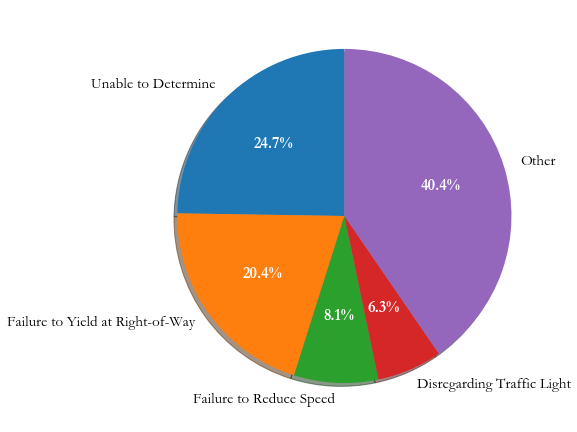

In [29]:
prime_cause_pivot = fatal_only_2.pivot_table(index='PRIM_CONTRIBUTORY_CAUSE', values='CRASH_RECORD_ID',
                                              fill_value=0, aggfunc='count').reset_index()
prime_cause_pivot.columns = ['desc', 'total']
prime_cause_pivot.sort_values(by='total', inplace=True, ascending = False)
prime_cause_pivot['prcnt_total'] = prime_cause_pivot['total'] / sum(prime_cause_pivot['total'])
prime_cause_pivot.reset_index(inplace=True)
prime_cause_pivot.drop('index', axis=1, inplace=True)

unable_to_detrmine = prime_cause_pivot.at[0, 'prcnt_total']
fail_right_of_way = prime_cause_pivot.at[1, 'prcnt_total']
fail_reduce_speed = prime_cause_pivot.at[2, 'prcnt_total']
disregard_signals = prime_cause_pivot.at[3, 'prcnt_total']
other_prime_cause = 1-(unable_to_detrmine + fail_right_of_way + fail_reduce_speed + disregard_signals)
cause_vals = np.array([unable_to_detrmine, fail_right_of_way, fail_reduce_speed, disregard_signals, other_prime_cause])
cause_labels = ['Unable to Determine', 'Failure to Yield at Right-of-Way', 'Failure to Reduce Speed', 
              'Disregarding Traffic Light','Other']
plt.rcParams['font.family'] = 'garamond'


fig, ax = plt.subplots(figsize=(8,8))
mpl.rcParams['font.size'] = 15
_, _, autotexts = ax.pie(cause_vals, startangle=90, labels=cause_labels, autopct='%1.1f%%', shadow=True, 
                         )
#ax.set_title('Device Controls Where Fatalies Occur', fontsize=22, fontweight='bold')
plt.setp(autotexts, weight='bold', size = 16, color="w");
plt.tight_layout()
fig.savefig('images/primary_cause.png')

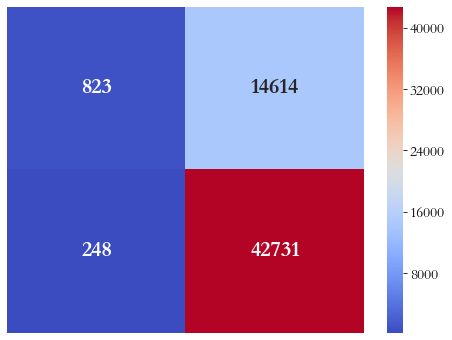

In [58]:
# Confusion matrix data from ML file.

plt.figure(figsize=(8,6))
conf_mtrx = np.array([[823, 14614],[248, 42731]])

ax = sns.heatmap(conf_mtrx,cmap='coolwarm',annot=True, annot_kws={'size': 22, 'fontweight':'bold'}, fmt='d',
                 xticklabels=False, yticklabels=False);
ax.tick_params(axis='both', which='both', length=0)
plt.savefig('xgb_confusion_matrix.png', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
device_pivot

In [ ]:
len(accidents) == len(accidents2)

---
# CREATE THE FINAL DATASET

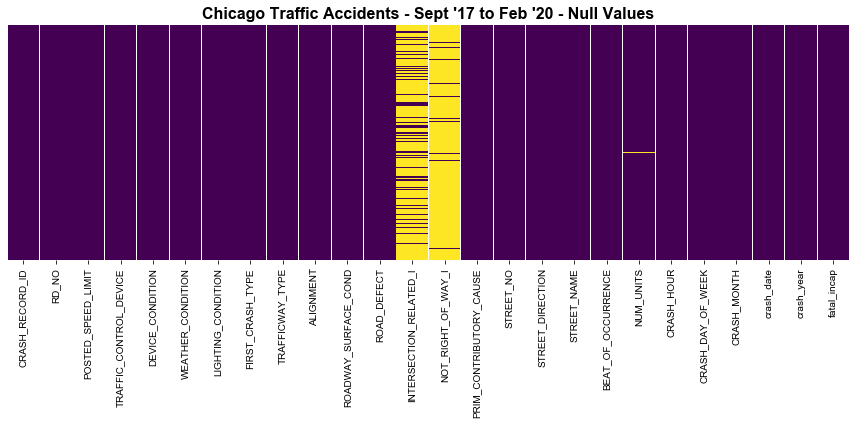

In [14]:
plt.figure(figsize=(12,6))
sns.heatmap(accidents2.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title("Chicago Traffic Accidents - Sept '17 to Feb '20 - Null Values", fontsize=16, fontweight='bold')
plt.savefig('chi_accidents_null.png');
plt.tight_layout();

In [15]:
accidents['NUM_UNITS'].unique()

array([ 2.,  3.,  1., nan,  4.,  8.,  5.,  6.,  7., 10.,  9., 18., 15.,
       11., 12., 16.])

---
## Create X Subsets for Model Train/Test

#### Variables are imbalanced.

# Y

In [24]:
y_all_true = accidents2[['fatal_incap']]

---
## X1